In [1]:
from environments.e_greedy import DeepTradingEnvironment, LinearAgent
import datetime
import numpy as np
import pandas as pd
import os
from utils import train_val_test
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.cla import CLA
import matplotlib.pyplot as plt
from matplotlib import cm
import copy

# Utility Functions

In [2]:
def linear_agent_train(env, weights):
    x=np.array(list(weights.values())).reshape(-1,1)
    p_vol=np.sqrt(np.matmul(np.matmul(x.T,cov),x))
    p_sharpe=np.matmul(x.T,mus)/p_vol
    linear_agent=LinearAgent(environment=env,out_reward_window_td=out_reward_window,
                             reward_function="cum_return",sample_observations=4)
    linear_agent.set_plot_weights(weights=np.array(list(weights.values())),
                                  benchmark_G=-p_vol.ravel()[0])
    return linear_agent

In [3]:
root = os.getcwd()

def plot_backtest(linear_agent_train, env_test, model):
    ## Create Plot of Backtest
    if not "backtest" in locals():
        backtest=None
    backtest=linear_agent_train.backtest_policy(epoch=1,backtest=backtest, env_test=env_test)
    plt.figure(figsize=(12,6))
    plt.plot(backtest,color="blue")
    plt.gcf().autofmt_xdate()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Date", fontsize = 14)
    plt.ylabel("Forward Returns", fontsize = 14)
    plt.title("Backtest on Test Data: "+ model,fontsize = 16)
    plt.savefig(root+'/temp_persisted_data/backtest_'+model+'.png')
    plt.show()
    return backtest

In [4]:
def plot_weights(weights, model):
    labels = pd.Series(weights.index)
    labels = labels.str.split('.').str[0]
    cs=cm.Set1(np.arange(len(labels))/len(labels))

    plt.figure(figsize=(12,6))
    plt.pie(weights, autopct='%1.1f%%', startangle=0, labels=labels, colors=cs)
    plt.axis('equal')  
    plt.title("Distribution of Weights: "+model, fontsize=14)
    plt.savefig(root+'/temp_persisted_data/weights_'+model+'.png')
    plt.show()

# Train-Test Split

#### List ETFs with data

In [5]:
data_env = root+"/data_env/"
os.listdir(data_env)

['EEMV.parquet',
 'EFAV.parquet',
 'MTUM.parquet',
 'QUAL.parquet',
 'SIZE.parquet',
 'USMV.parquet',
 'VLUE.parquet']

In [6]:
# read a sample ETF
pd.read_parquet(data_env+'EEMV.parquet')

,open,high,low,close,volume
index,,,,,
2017-01-03 05:00:00+00:00,45.08700,45.26144,44.93093,45.07782,926496
2017-01-04 05:00:00+00:00,45.50014,45.63785,45.50014,45.54604,973660
2017-01-05 05:00:00+00:00,45.92245,46.16116,45.92245,46.14280,646347
2017-01-06 05:00:00+00:00,45.94082,45.94082,45.74802,45.81229,563348
2017-01-09 05:00:00+00:00,45.71130,45.79393,45.65621,45.71130,615522
...,...,...,...,...,...
2020-11-17 05:00:00+00:00,59.16000,59.61500,59.14500,59.46000,265100
2020-11-18 05:00:00+00:00,59.50000,59.67000,59.36000,59.36000,735100
2020-11-19 05:00:00+00:00,59.15000,59.50840,59.07010,59.41000,170500


#### Store ETFs in Pandas DataFrame

In [7]:
assets_dict = {file: pd.read_parquet(data_env + "/" + file) for file in os.listdir(data_env)}
counter=0
for key, value in assets_dict.items():
    if counter==0:
        main_index=value.index
    else:
        main_index=main_index.join(value.index,how="inner")

for key, value in assets_dict.items():
    tmp_df=value.reindex(main_index)
    tmp_df=tmp_df.fillna(method='ffill')
    assets_dict[key]=tmp_df['close']

In [8]:
portfolio_df = pd.DataFrame()

for key, value in assets_dict.items():
    key = key.split(".")[0]
    tmp_df = pd.DataFrame(data=value)
    tmp_df.columns=[key]
    portfolio_df = pd.concat([portfolio_df, tmp_df], axis=1)

portfolio_df.index = pd.to_datetime(portfolio_df.index, errors='coerce').tz_localize(None)

In [9]:
forward_return_date = pd.Timedelta(days=1)
return_dates = pd.Series(portfolio_df.index) + forward_return_date
y = pd.Series(None)

C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


#### Perform Train/Test Split

In [10]:
last_index, embargo_td = train_val_test(portfolio_df, y, return_dates)

#### Write Training and Test datasets to parquet files

In [11]:
assets_dict = {file: pd.read_parquet(data_env + "/" + file) for file in os.listdir(data_env)}
for file in os.listdir(data_env):
    tmp_df = pd.read_parquet(data_env + "/" + file)

    tmp_df_train = tmp_df.iloc[:last_index-embargo_td]
    tmp_df_train.to_parquet("data_env_train/" + file)
    tmp_df_test = tmp_df.iloc[last_index:] 
    tmp_df_test.to_parquet("data_env_test/" + file)

In [12]:
# read a sample training set ETF
data_env_train = root+"/data_env_train/"
pd.read_parquet(data_env_train+'EEMV.parquet')

,open,high,low,close,volume
index,,,,,
2017-01-03 05:00:00+00:00,45.08700,45.26144,44.93093,45.07782,926496
2017-01-04 05:00:00+00:00,45.50014,45.63785,45.50014,45.54604,973660
2017-01-05 05:00:00+00:00,45.92245,46.16116,45.92245,46.14280,646347
2017-01-06 05:00:00+00:00,45.94082,45.94082,45.74802,45.81229,563348
2017-01-09 05:00:00+00:00,45.71130,45.79393,45.65621,45.71130,615522
...,...,...,...,...,...
2019-09-17 04:00:00+00:00,56.04434,56.48264,56.04434,56.48264,225049
2019-09-18 04:00:00+00:00,56.38524,56.42420,55.97616,56.30732,375767
2019-09-19 04:00:00+00:00,56.14174,56.36576,56.07355,56.15148,225563


In [13]:
# read a sample test set ETF
data_env_test = root+"/data_env_test/"
pd.read_parquet(data_env_test+'EEMV.parquet')

,open,high,low,close,volume
index,,,,,
2019-09-25 04:00:00+00:00,55.56707,55.89824,55.48311,55.78135,281004
2019-09-26 04:00:00+00:00,55.75214,55.75827,55.55587,55.68395,241168
2019-09-27 04:00:00+00:00,55.77161,55.83006,55.14796,55.31383,254002
2019-09-30 04:00:00+00:00,55.61577,55.77161,55.52811,55.60603,698044
2019-10-01 04:00:00+00:00,55.44045,55.50182,55.16773,55.21643,431721
...,...,...,...,...,...
2020-11-17 05:00:00+00:00,59.16000,59.61500,59.14500,59.46000,265100
2020-11-18 05:00:00+00:00,59.50000,59.67000,59.36000,59.36000,735100
2020-11-19 05:00:00+00:00,59.15000,59.50840,59.07010,59.41000,170500


# Set Up Environment

#### Environment for Training Data

In [14]:
out_reward_window=datetime.timedelta(days=1)
# parameters related to the transformation of data, this parameters govern an step before the algorithm
meta_parameters = {"in_bars_count": 30,
                   "out_reward_window":out_reward_window ,
                   "state_type":"in_window_out_window",
                   "include_previous_weights":False}

# parameters that are related to the objective/reward function construction
objective_parameters = {"percent_commission": .001,
                        }
print("===Meta Parameters===")
print(meta_parameters)
print("===Objective Parameters===")
print(objective_parameters)


env = DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters, objective_parameters,data_hash="real_data_train", data_dir="data_env_train")

number_of_assets = env.number_of_assets

sigma = np.zeros(number_of_assets)
mus = np.zeros(number_of_assets)
for i in range(0,number_of_assets):
    sigma[i] = np.std(env.features.iloc[:,i])**2
    mus[i] = np.mean(env.features.iloc[:,i])
    
cov = np.zeros((number_of_assets, number_of_assets))
np.fill_diagonal(cov, sigma)

ef = EfficientFrontier(mus, cov)
# weights = ef.max_sharpe(risk_free_rate=0)
weights = ef.min_volatility()
print("===Minimum volatility weights===")
print(weights)


===Meta Parameters===
{'in_bars_count': 30, 'out_reward_window': datetime.timedelta(days=1), 'state_type': 'in_window_out_window', 'include_previous_weights': False}
===Objective Parameters===
{'percent_commission': 0.001}
===Minimum volatility weights===
OrderedDict([(0, 0.1523506767722016), (1, 0.2648463104683026), (2, 0.0754890091777455), (3, 0.1054247535292877), (4, 0.125629427669176), (5, 0.1816663081241996), (6, 0.0945935142590883)])


#### Environment for Test Data

In [15]:
env_test = DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters, objective_parameters,data_hash="real_data_test", data_dir="data_env_test")

# Run Policy-Gradient Algorithms on Real-World Data

#### REINFORCE

In [16]:
max_iter = 1000

# create environment and run REINFORCE
env_reinforce = DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters, objective_parameters,data_hash="real_data_train", data_dir="data_env_train")
linear_agent_reinforce = linear_agent_train(env_reinforce, weights)
linear_agent_reinforce.REINFORCE_fit(max_iterations=max_iter, add_baseline=False, verbose=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 13.83it/s]

[]

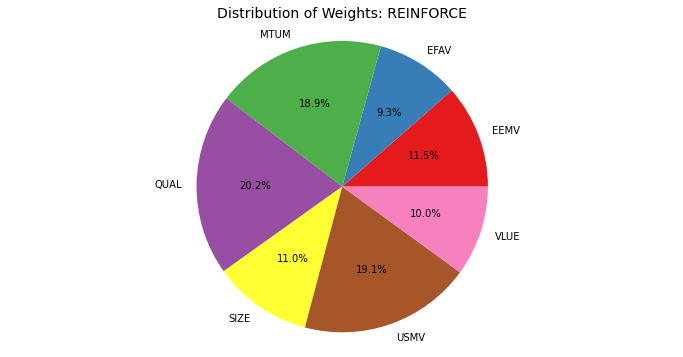

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 17.90it/s]


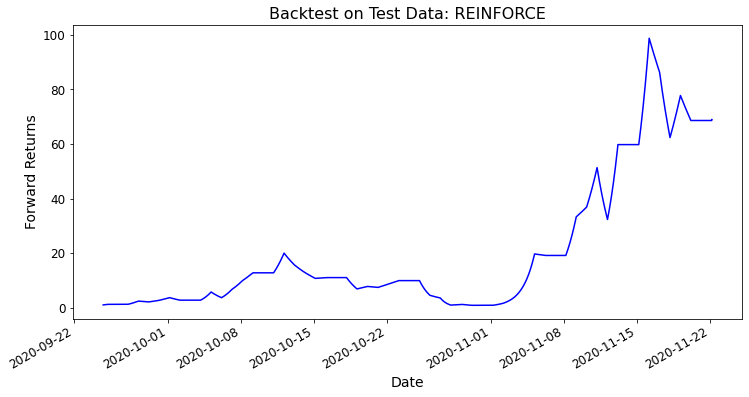

In [17]:
# save weights from training model run
reinforce_train_weights = env_reinforce.state.weight_buffer.iloc[-1]
reinforce_train_weights.to_csv('temp_persisted_data/reinforce_train_weights.csv')

# load weights from training model run
reinforce_train_weights = pd.read_csv('temp_persisted_data/reinforce_train_weights.csv',  index_col=0).squeeze()
plot_weights(reinforce_train_weights, model="REINFORCE")

# perform backtest 
backtest_reinforce = plot_backtest(linear_agent_reinforce, env_test, model="REINFORCE")
backtest_reinforce.to_csv('temp_persisted_data/backtest_reinforce.csv')

#### REINFORCE with Baseline

In [18]:
# create environment and run REINFORCE with baseline
env_reinforce_baseline = DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters, objective_parameters,data_hash="real_data_train", data_dir="data_env_train")
linear_agent_reinforce_baseline = linear_agent_train(env_reinforce_baseline, weights)
linear_agent_reinforce_baseline.REINFORCE_fit(max_iterations=max_iter, add_baseline=True, verbose=False)

100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:37<00:00, 40.92it/s]

[]

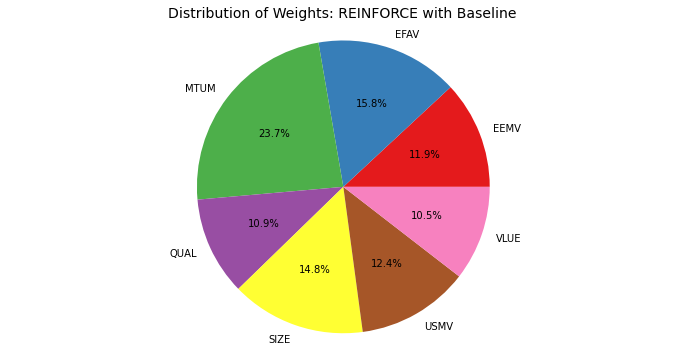

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.79it/s]


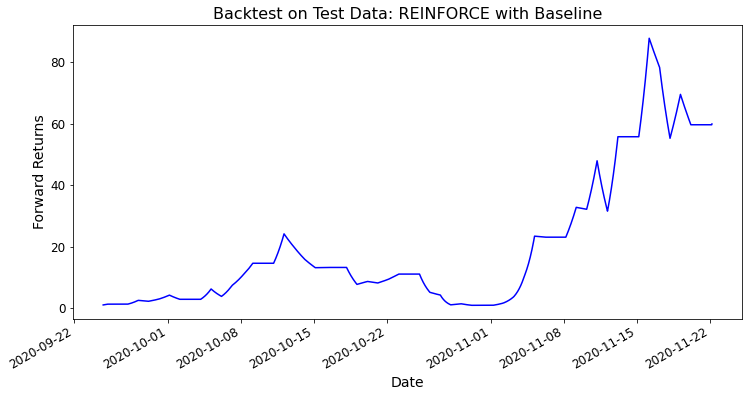

In [19]:
# save weights from training model run
reinforce_baseline_train_weights = env_reinforce_baseline.state.weight_buffer.iloc[-1]
reinforce_baseline_train_weights.to_csv('temp_persisted_data/reinforce_baseline_train_weights.csv')

# load weights from training model run
reinforce_baseline_train_weights = pd.read_csv('temp_persisted_data/reinforce_baseline_train_weights.csv',  index_col=0).squeeze()
plot_weights(reinforce_baseline_train_weights, model="REINFORCE with Baseline")

# perform backtest 
backtest_reinforce_baseline = plot_backtest(linear_agent_reinforce_baseline, env_test, model="REINFORCE with Baseline")
backtest_reinforce_baseline.to_csv('temp_persisted_data/backtest_reinforce_baseline.csv')

#### Actor-Critic with Eligibility Traces

In [20]:
# create environment and run Actor-Critic with Eligibility Traces 
env_actor_critic_trace = DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters, objective_parameters,data_hash="real_data_train", data_dir="data_env_train")
linear_agent_actor_critic_trace = linear_agent_train(env_actor_critic_trace, weights)
linear_agent_actor_critic_trace.ACTOR_CRITIC_FIT(use_traces=True,max_iterations=max_iter, verbose=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 28.36it/s]

[]

C:\Users\micha\anaconda3\envs\e599a_py37\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  import sys


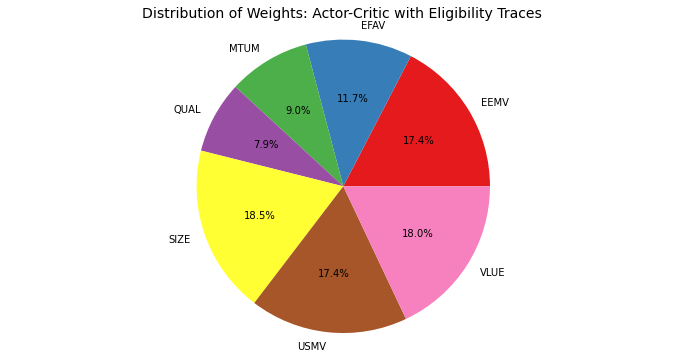

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.86it/s]


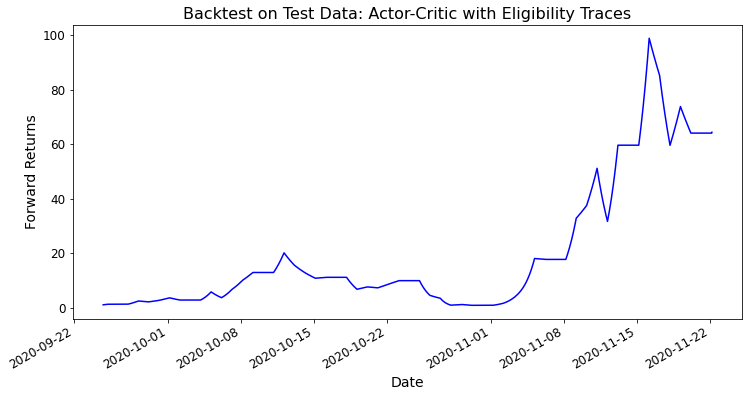

In [21]:
# save weights from training model run
actor_critic_trace_train_weights = env_actor_critic_trace.state.weight_buffer.iloc[-1]
actor_critic_trace_train_weights.to_csv('temp_persisted_data/actor_critic_trace_train_weights.csv')

# load weights from training model run
actor_critic_trace_train_weights = pd.read_csv('temp_persisted_data/actor_critic_trace_train_weights.csv',  index_col=0).squeeze()
plot_weights(actor_critic_trace_train_weights, model="Actor-Critic with Eligibility Traces")

# perform backtest 
backtest_actor_critic_trace = plot_backtest(linear_agent_actor_critic_trace, env_test, model="Actor-Critic with Eligibility Traces")
backtest_actor_critic_trace.to_csv('temp_persisted_data/backtest_actor_critic_trace.csv')

#### Actor-Critic without Eligibility Traces

In [22]:
# create environment and run Actor-Critic with Eligibility Traces 
env_actor_critic_no_trace = DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters, objective_parameters,data_hash="real_data_train", data_dir="data_env_train")

linear_agent_actor_critic_no_trace = linear_agent_train(env_actor_critic_no_trace, weights)
linear_agent_actor_critic_no_trace.ACTOR_CRITIC_FIT(use_traces=False,max_iterations=max_iter, verbose=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:49<00:00, 15.55it/s]

[]

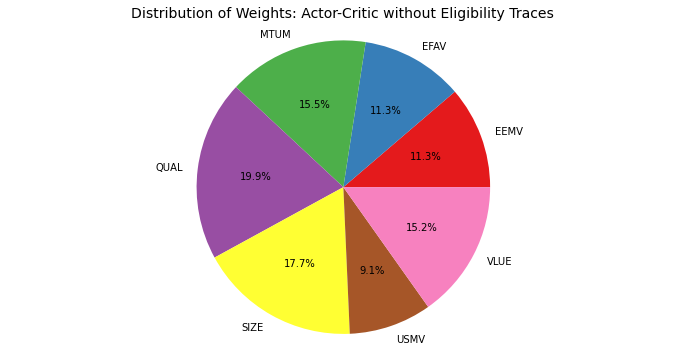

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.91it/s]


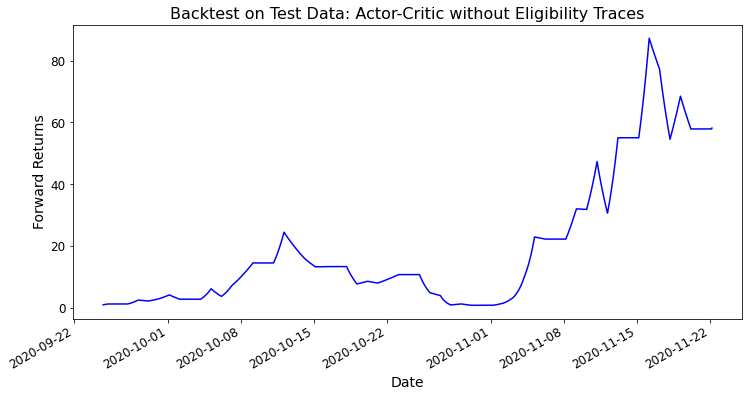

In [23]:
# save weights from training model run
actor_critic_no_trace_train_weights = env_actor_critic_no_trace.state.weight_buffer.iloc[-1]
actor_critic_no_trace_train_weights.to_csv('temp_persisted_data/actor_critic_no_trace_train_weights.csv')

# load weights from training model run
actor_critic_no_trace_train_weights = pd.read_csv('temp_persisted_data/actor_critic_no_trace_train_weights.csv',  index_col=0).squeeze()
plot_weights(actor_critic_no_trace_train_weights, model="Actor-Critic without Eligibility Traces")

# perform backtest
backtest_actor_critic_no_trace = plot_backtest(linear_agent_actor_critic_no_trace, env_test, model="Actor-Critic without Eligibility Traces")
backtest_actor_critic_no_trace.to_csv('temp_persisted_data/backtest_actor_critic_no_trace.csv')

In [24]:
pd.options.display.float_format = '{:.1%}'.format
combined_weights = pd.DataFrame([reinforce_train_weights, reinforce_baseline_train_weights, actor_critic_trace_train_weights, actor_critic_no_trace_train_weights ]).T
combined_weights.index = pd.Series(reinforce_train_weights.index).str.split('.').str[0]
combined_weights.columns=['REINFORCE', 'REINFORCE with Baseline', 'Actor-Critic with Eligibility Traces', 'Actor-Critic without Eligibility Traces']

combined_weights

,REINFORCE,REINFORCE with Baseline,Actor-Critic with Eligibility Traces,Actor-Critic without Eligibility Traces
EEMV,11.5%,11.9%,17.4%,11.3%
EFAV,9.3%,15.8%,11.7%,11.3%
MTUM,18.9%,23.7%,9.0%,15.5%
QUAL,20.2%,10.9%,7.9%,19.9%
SIZE,11.0%,14.8%,18.5%,17.7%
USMV,19.1%,12.4%,17.4%,9.1%
VLUE,10.0%,10.5%,18.0%,15.2%
